In [2]:
# Astro Denoiser – Noise2Noise + Noise2Stack hybrid training
# Copyright Andriy Melnykov 2025

# Images are TIFF, 16-bit RGB
# Folder structure:
#
# MyDrive/Colab_Data/
# └── astro_denoise/
#     ├── data/
#         ├── object_01/
#         │   ├── subs/
#         │   │   ├── sub_01.tif
#         │   │   ├── sub_02.tif
#         │   │   └── …
#         │   └── stack.tif
#         ├── object_02/
#         │   └── …
#         └── …


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

ROOT = "/content/drive/MyDrive/Colab_Data/astro_denoise"
DATA = f"{ROOT}/data/"


# Libraries
!pip install imagecodecs
print("Libraries install done")

import os, glob, random, math
import numpy as np
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.ndimage import gaussian_filter
print("Libraries import done")

IMAGE_SIZE_X = 1500     # image width
IMAGE_SIZE_Y = 1500     # image height
PATCH  = 128            # patch size NxN
STRIDE = 32             # stride for patch generation
EDGE_CROP = 150         # not used edge of dataset images
P_N2N = 0.7             # probability of picking a Noise2Noise pair in hybrid training
BATCH = 1024            # batch size for training
EPOCHS_N2N = 20         # epochs number for pure N2N
EPOCHS_HYB = 20         # epochs number for hybrid (N2N + N2S)
EPOCHS_N2S = 20         # epochs number for N2Stack only
SHARPEN_STACKS = False  # activates sharpening for target stacks
SHARPEN_SIGMA = 2.0     # sigma (~radius) for sharpening in pixels
SHARPEN_AMOUNT = 0.3    # amount of sharpening
STRETCH_PATCHES = True  # activates random stretching (tone curve) for both source/target patches
P_GAMMA=0.5             # probability of random stretching
GAMMA_RANGE=(0.8, 1.2)  # range of gamma for random stretching


# Scan Drive and index all subs / stacks
print("Loading dataset structure...")

objects = {}
for obj_dir in sorted(glob.glob(f"{DATA}/object_*")):
    subs = sorted(glob.glob(f"{obj_dir}/subs/*.tiff"))
    stack = f"{obj_dir}/stack.tiff"
    if subs and os.path.exists(stack):
        objects[obj_dir] = {"subs": subs, "stack": stack}
print(f"Found {len(objects)} objects, {sum(len(v['subs']) for v in objects.values())} subs")


# Pre-compute patch coordinates (same for every frame)
def grid_coords(size_x=IMAGE_SIZE_X, size_y=IMAGE_SIZE_Y, patch=PATCH, stride=STRIDE, crop=EDGE_CROP):
    xs = range(crop, IMAGE_SIZE_X - crop - patch + 1, stride)
    ys = range(crop, IMAGE_SIZE_Y - crop - patch + 1, stride)
    return [(y,x) for y in ys for x in xs]

PATCH_COORDS = grid_coords()
print(f"{len(PATCH_COORDS)} patch locations per frame")


train_objs = objects   # all objects used for training, no validation data


# Simple unsharp mask for float32 RGB in [0,1].
# sigma  – Gaussian sigma in pixels
# amount – strength
def unsharp_mask(img, sigma=1.0, amount=0.15):
    blur  = gaussian_filter(img, sigma=(sigma, sigma, 0))
    sharp = img + amount * (img - blur)
    return np.clip(sharp, 0.0, 1.0)


# RAM-backed data generator
# Images are TIFF, 16-bit RGB
def preload_images(objs, dtype=np.float32):
    """Read every sub & stack into a nested dict of numpy arrays."""
    i=1
    cache = {}
    for obj_dir, meta in objs.items():
        frames = {}
        for p in meta["subs"] + [meta["stack"]]:
            arr = tiff.imread(p).astype(dtype)
            arr = arr / 65535.0
            if SHARPEN_STACKS and p == meta["stack"]:
                arr = unsharp_mask(arr, sigma=SHARPEN_SIGMA, amount=SHARPEN_AMOUNT)
            frames[p] = arr
            if p == meta["stack"]:
                print("Object ", i, "loaded")
                i+=1
        cache[obj_dir] = frames
    return cache


# Pre-load images once
print("Loading images...")
RAM_CACHE_TRAIN = preload_images(train_objs)
print("Images loaded")


def apply_random_stretch(src, tgt,
                         p_gamma=0.5,
                         gamma_range=(0.8, 1.2)):
    #Apply the *same* nonlinear stretch to src & tgt.
    #50 % chance: power-law γ curve   x_out = x**γ
    #Arguments are two float32 arrays in [0,1]; returns transformed copies.

    if np.random.rand() < p_gamma:         # γ-stretch
        g = np.random.uniform(*gamma_range)
        return src ** g, tgt ** g
    else:
        return src, tgt

def random_rot_flip(src, tgt):
    #Rotate both patches by k×90° and optionally flip horizontally.
    #Input & output: float32 arrays (64,64,3).
    k = np.random.randint(0, 4)          # 0,1,2,3  → rot90
    if k:
        src = np.rot90(src, k, axes=(0,1))
        tgt = np.rot90(tgt, k, axes=(0,1))

    if np.random.rand() < 0.5:           # 50 % chance mirror
        src = np.flip(src, axis=1)       # horizontal flip
        tgt = np.flip(tgt, axis=1)

    return src, tgt


# Patch generator
class HybridGeneratorRAM(keras.utils.Sequence):
    def __init__(self, objs, ram_cache, mode="hybrid", p_n2n=P_N2N,
                 shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.objs = list(objs.items())      # (obj_dir, meta)
        self.rc   = ram_cache               # nested dict with arrays
        self.mode = mode
        self.p_n2n = p_n2n
        self.shuffle = shuffle

        # flat index over (object, patch-coord)
        self.idxs = np.arange(len(self.objs) * len(PATCH_COORDS))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.idxs) / BATCH)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.idxs)

    def __getitem__(self, idx):
        batch_idxs = self.idxs[idx*BATCH:(idx+1)*BATCH]
        srcs, tgts = [], []
        for flat in batch_idxs:
            obj_i, loc_i = divmod(flat, len(PATCH_COORDS))
            obj_dir, meta = self.objs[obj_i]
            y, x = PATCH_COORDS[loc_i]

            # pick random source sub
            src_path = random.choice(meta["subs"])
            src = self.rc[obj_dir][src_path][y:y+PATCH, x:x+PATCH]

            use_n2n = (self.mode=="n2n") or (self.mode=="hybrid" and random.random() < self.p_n2n)
            if use_n2n:
                tgt_path = random.choice([p for p in meta["subs"] if p != src_path])
            else:
                tgt_path = meta["stack"]
            tgt = self.rc[obj_dir][tgt_path][y:y+PATCH, x:x+PATCH]

            if STRETCH_PATCHES:
                src, tgt = apply_random_stretch(src, tgt, p_gamma=P_GAMMA, gamma_range=GAMMA_RANGE)

            src, tgt = random_rot_flip(src, tgt)

            srcs.append(src);  tgts.append(tgt)

        return np.stack(srcs), np.stack(tgts)



train_gen = HybridGeneratorRAM(train_objs, RAM_CACHE_TRAIN, mode="hybrid")


# Different loss functions
def hybrid_loss(y_true, y_pred):
    mse  = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = tf.reduce_mean(1. - tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse + 0.1 * ssim

def charbonnier(x, y, eps=1e-3):
    return tf.reduce_mean(tf.sqrt(tf.square(x - y) + eps**2))

def mixed_loss(y_true, y_pred):
    l1   = tf.reduce_mean(charbonnier(y_true, y_pred))
    ssim = 1. - tf.image.ssim(y_true, y_pred, max_val=1.0)
    return l1 + 0.1*tf.reduce_mean(ssim)

def gradient_loss(y_true, y_pred, alpha=0.2):
    # basic pixel loss (Charbonnier or MSE)
    base = tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + 1e-3**2))
    # high-frequency term: sobel gradients
    sobel = tf.image.sobel_edges
    grad_true = sobel(y_true)
    grad_pred = sobel(y_pred)
    hf = tf.reduce_mean(tf.abs(grad_true - grad_pred))
    return base + alpha * hf        # alpha≈0.1–0.3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries install done
Libraries import done
Loading dataset structure...
Found 1 objects, 10 subs
1156 patch locations per frame
Loading images...
Object  1 loaded
Images loaded


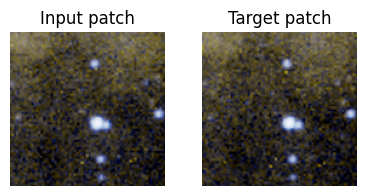

In [5]:
# For testing: visualise one random (src, tgt) patch pair
import matplotlib.pyplot as plt
import random, numpy as np

# For Noise2Noise patch generator:
train_gen.mode, train_gen.p_n2n = "n2n", 1.0

# For Noise2Stack patch generator:
#train_gen.mode, train_gen.p_n2n = "stack", 0.0

# --- get a random batch and a random sample inside it
batch_src, batch_tgt = train_gen[random.randrange(len(train_gen))]
k = random.randrange(batch_src.shape[0])

src_patch  = batch_src[k]     # (64,64,3) float32
tgt_patch  = batch_tgt[k]

# --- plot
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

axs[0].imshow(src_patch)
axs[0].set_title("Input patch")

axs[1].imshow(tgt_patch)
axs[1].set_title("Target patch")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Model definition DnCNN-light V1
def build_train13(patch=PATCH, ch=3, filters=9, depth=2):
    inp = keras.Input(shape=(patch, patch, ch))
    x   = layers.Conv2D(filters, (7,7), padding="same", activation="relu")(inp)
    for _ in range(depth):
        x = layers.Conv2D(filters, (7,7), padding="same", activation="relu")(x)
    x = layers.Conv2D(ch, (3,3), padding="same")(x)
    out = layers.Subtract()([inp, x])        # residual
    return keras.Model(inp, out, name="train13")

model = build_train13()
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='MSE')
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=hybrid_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=mixed_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=gradient_loss)
model.summary()

Model: "train13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,332 │ input_layer[0][0] │
│                     │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      3,978 │ conv2d[0][0]      │
│                     │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      3,978 │ conv2d_1[0][0]    │
│                     │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        246 │ conv2d_2[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 128, 128,  │          0 │ input_layer[0][0… │
│                     │ 3)                │            │ conv2d_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,534 (37.24 KB)

 Trainable params: 9,534 (37.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model definition DnCNN-light V2
def build_train14(patch=PATCH, ch=3, filters=14, depth=4):
    inp = keras.Input(shape=(patch, patch, ch))
    x   = layers.Conv2D(filters, 5, padding="same", activation="relu")(inp)
    for _ in range(depth):
        x = layers.Conv2D(filters, 5, padding="same", activation="relu")(x)
    x = layers.Conv2D(ch, 3, padding="same")(x)
    out = layers.Subtract()([inp, x])        # residual
    return keras.Model(inp, out, name="train14")

model = build_train14()
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='MSE')
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=hybrid_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=mixed_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=gradient_loss)
model.summary()

In [ ]:
# Model definition DnCNN-tiny
def build_train11(patch=PATCH, ch=3):
    inp = keras.Input(shape=(patch, patch, ch))

    x = layers.Conv2D(16, 3, padding='same', activation='relu')(inp)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)

    # Predict the residual (noise) and subtract it
    noise = layers.Conv2D(ch, 3, padding='same', activation=None)(x)
    out   = layers.Subtract()([inp, noise])
    return keras.Model(inp, out, name="train11")

model = build_train11()
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='MSE')
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=hybrid_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=mixed_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=gradient_loss)
model.summary()

In [ ]:
# Model definition DnCNN-big

def build_train15(patch=PATCH, ch=3, f=32, depth=8):
    inp = keras.Input(shape=(patch, patch, ch))
    x   = layers.Conv2D(f, 3, padding="same", activation="relu")(inp)
    for _ in range(depth):
        x   = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    res = layers.Conv2D(ch, 3, padding="same")(x)
    out = layers.Subtract()([inp, res])
    return keras.Model(inp, out, name="train15")

model = build_train15()
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='MSE')
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=hybrid_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=mixed_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=gradient_loss)
model.summary()

In [ ]:
# Model definition DnCNN-big V2

def build_train16(patch=PATCH, ch=3, f=32, depth=8):
    inp = keras.Input(shape=(patch, patch, ch))
    x   = layers.Conv2D(f, 7, padding="same", activation="relu")(inp)
    for _ in range(depth):
        x   = layers.Conv2D(f, 7, padding="same", activation="relu")(x)
    res = layers.Conv2D(ch, 3, padding="same")(x)
    out = layers.Subtract()([inp, res])
    return keras.Model(inp, out, name="train16")

model = build_train16()
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='MSE')
#model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=hybrid_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=mixed_loss)
#model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=gradient_loss)
model.summary()

In [ ]:
# Optionally load model from drive

model = keras.models.load_model('/content/drive/MyDrive/Colab_Data/astro_denoise/train_16.keras', compile=False)
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='MSE')
#model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=mixed_loss)
model.summary()

In [14]:
# Training Noise2Noise
if EPOCHS_N2N > 0:
    train_gen.mode = "n2n";  train_gen.p_n2n = 1.0
    model.fit(train_gen, epochs=EPOCHS_N2N, validation_data=None)
    print("Training done")

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0035
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0035
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0035
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0034
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 

In [ ]:
# Training hybrid
if EPOCHS_HYB > 0:
    train_gen.mode = "hybrid";  train_gen.p_n2n = P_N2N
    model.fit(train_gen, epochs=EPOCHS_HYB, validation_data=None)
    print("Training done")

In [ ]:
# Training Noise2Stack
if EPOCHS_N2S > 0:
    train_gen.mode = "stack";  train_gen.p_n2n = 0.0
    model.fit(train_gen, epochs=EPOCHS_N2S, validation_data=None)
    print("Training done")

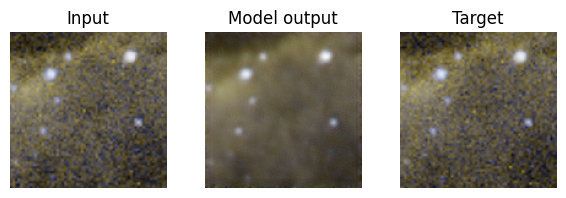

In [19]:
# Inspect the trained model on a random 64×64 patch
import matplotlib.pyplot as plt, random, numpy as np

# take a random batch from the generator
batch_src, batch_tgt = train_gen[random.randrange(len(train_gen))]

# pick a random index inside that batch
k = random.randrange(batch_src.shape[0])
src_patch   = batch_src[k][None, ...]     # add batch-axis for .predict()
tgt_patch   = batch_tgt[k]

# run the model
pred_patch  = model.predict(src_patch, verbose=0)[0]   # remove batch-axis

# visualise
titles = ["Input", "Model output", "Target"]
fig, axs = plt.subplots(1, 3, figsize=(6, 2))
for ax, img, title in zip(axs, [src_patch[0], pred_patch, tgt_patch], titles):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title); ax.axis("off")
plt.tight_layout(); plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab_Data/astro_denoise/train_16.keras')

In [ ]:
drive.flush_and_unmount()